<a href="https://colab.research.google.com/github/fjme95/aplicaciones-financieras/blob/main/Modulo%203/Semana%202/Hierarchical_Risk_Parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLA.py

Critical Line Algorithm (CLA) es un algoritmo para obtener portafolios con mínima varianza sin la necesidad de utilizar programación cuadrática.

Obtenido de 

> David H. Bailey and Marcos Lopez de Prado, "An open-source implementation of the critical line algorithm for portfolio optimization," Algorithms, vol. 6 (2013), pg. 169-196, DOI: 10.3390/a6010169

Se puede encontrar la [publicación](https://ssrn.com/abstract=2197616) y el [código](https://www.davidhbailey.com/dhbpapers/CLA-files.zip) en https://www.davidhbailey.com/dhbpapers/.

In [ ]:
%%writefile CLA.py
#!/usr/bin/env python
# On 20121129
# Critical Line Algorithm
# by MLdP <lopezdeprado@lbl.gov>

import numpy as np
#---------------------------------------------------------------
#---------------------------------------------------------------
class CLA:
    def __init__(self,mean,covar,lB,uB):
        # Initialize the class
        self.mean=mean
        self.covar=covar
        self.lB=lB
        self.uB=uB
        self.w=[] # solution
        self.l=[] # lambdas
        self.g=[] # gammas
        self.f=[] # free weights
#---------------------------------------------------------------
    def solve(self):
        # Compute the turning points,free sets and weights
        f,w=self.initAlgo()
        self.w.append(np.copy(w)) # store solution
        self.l.append(None)
        self.g.append(None)
        self.f.append(f[:])
        while True:
            #1) case a): Bound one free weight
            l_in=None
            if len(f)>1:
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                j=0
                for i in f:
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,j,[self.lB[i],self.uB[i]])
                    if l_in is None or l>l_in:l_in,i_in,bi_in=l,i,bi
                    j+=1
            #2) case b): Free one bounded weight
            l_out=None
            if len(f)<self.mean.shape[0]:
                b=self.getB(f)
                for i in b:
                    covarF,covarFB,meanF,wB=self.getMatrices(f+[i])
                    covarF_inv=np.linalg.inv(covarF)
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,meanF.shape[0]-1, \
                        self.w[-1][i])
                    if (self.l[-1]==None or l<self.l[-1]) and (l_out is None or l>l_out):
                        l_out,i_out=l,i                
            #3) decide lambda
            if (l_in==None or l_in<0) and (l_out==None or l_out<0):break
            if l_in is not None and (l_out is None or l_in > l_out):
                self.l.append(l_in)
                f.remove(i_in)
                w[i_in]=bi_in # set value at the correct boundary
            else:
                self.l.append(l_out)
                f.append(i_out)
            #4) compute solution vector
            covarF,covarFB,meanF,wB=self.getMatrices(f)
            covarF_inv=np.linalg.inv(covarF)
            wF,g=self.computeW(covarF_inv,covarFB,meanF,wB)
            for i in range(len(f)):w[f[i]]=wF[i]
            self.w.append(np.copy(w)) # store solution
            self.g.append(g)
            self.f.append(f[:])
            if len(f)==self.mean.shape[0]:
                #5) minimum variance solution
                wF,g=self.computeW(covarF_inv,covarFB,np.zeros(meanF.shape),wB)
                for i in range(len(f)):w[f[i]]=wF[i]
                self.w.append(np.copy(w)) # store solution
                self.g.append(g)
                self.f.append(f[:])
#---------------------------------------------------------------    
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a=np.zeros((self.mean.shape[0]),dtype=[('id',int),('mu',float)])
        b=[self.mean[i][0] for i in range(self.mean.shape[0])] # dump array into list
        a[:]=list(zip(range(self.mean.shape[0]),b)) # fill structured array
        #2) Sort structured array
        b=np.sort(a,order='mu')
        #3) First free weight
        i,w=b.shape[0],np.copy(self.lB)
        while sum(w)<1:
            i-=1
            w[b[i][0]]=self.uB[b[i][0]]
        w[b[i][0]]+=1-sum(w)
        return [b[i][0]],w
#---------------------------------------------------------------    
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1]
        if c<0:
            bi=bi[0]
        return bi
#---------------------------------------------------------------
    def computeW(self,covarF_inv,covarFB,meanF,wB):
        #1) compute gamma
        onesF=np.ones(meanF.shape)
        g1=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        g2=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        if np.all(wB)==None:
            g,w1=float(-self.l[-1]*g1/g2+1/g2),0
        else:
            onesB=np.ones(wB.shape)
            g3=np.dot(onesB.T,wB)
            g4=np.dot(covarF_inv,covarFB)
            w1=np.dot(g4,wB)
            g4=np.dot(onesF.T,w1)
            g=float(-self.l[-1]*g1/g2+(1-g3+g4)/g2)
        #2) compute weights
        w2=np.dot(covarF_inv,onesF)
        w3=np.dot(covarF_inv,meanF)
        return -w1+g*w2+self.l[-1]*w3,g
#---------------------------------------------------------------
    def computeLambda(self,covarF_inv,covarFB,meanF,wB,i,bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if np.all(wB==None):
            # All free assets
            return float((c4[i]-c1*bi)/c),bi
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
#---------------------------------------------------------------
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF=self.reduceMatrix(self.covar,f,f)
        meanF=self.reduceMatrix(self.mean,f,[0])
        b=self.getB(f)
        covarFB=self.reduceMatrix(self.covar,f,b)
        wB=self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
#---------------------------------------------------------------
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
#---------------------------------------------------------------
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
#---------------------------------------------------------------
    def reduceMatrix(self,matrix,listX,listY):
        matrix = np.array(matrix)
        # Reduce a matrix to the provided list of rows and columns
        if len(listX)==0 or len(listY)==0:return
        matrix_=matrix[:,listY[0]:listY[0]+1]
        for i in listY[1:]:
            a=matrix[:,i:i+1]
            matrix_=np.append(matrix_,a,1)
        matrix__=matrix_[listX[0]:listX[0]+1,:]
        for i in listX[1:]:
            a=matrix_[i:i+1,:]
            matrix__=np.append(matrix__,a,0)
        return matrix__
#---------------------------------------------------------------
    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
#---------------------------------------------------------------
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
#---------------------------------------------------------------
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
#---------------------------------------------------------------
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed 
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
#---------------------------------------------------------------
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights
#---------------------------------------------------------------
#---------------------------------------------------------------

# Dependencia

In [ ]:
!pip install -U scipy yfinance

     |████████████████████████████████| 6.4 MB 4.6 MB/s 
     |████████████████████████████████| 63 kB 991 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch, random, numpy as np, pandas as pd, yfinance as yf
from scipy.spatial.distance import squareform
# import CLA

# Funciones

In [ ]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp = 1./np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [ ]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems,cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

Sirve para reorganizar las filas y las columnas de la matriz de covarianzas para que los valores más grandes se queden alrededos de la diagonal. Esta tiene un propiedad útil: Inversiones similares son posicionadas juntas y distintos son puestos lejos unos de otros.

In [ ]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0,sortIx.shape[0]*2,2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;j = df0.values-numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1],index = i+1)
        sortIx = sortIx.append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

Regresa los pesos del portafolio de acuerdo al agoritmo de HRP:

Para crear los pesos, se usa la "inverse-variance allocation", el algoritmo es el siguiente:

1. El algoritmo se inicializa:
  
  a. Creando una lista de objetos: $L = \left\{ L_0 \right\}$ con $L_0 = \left\{ n\right\}_{n=1, \dots, N}$

  b. Asignando un peso unitario a todos los objetos: $w_n = 1$, $\forall n = 1, \dots, N$

2. Si $\|L_i\| = 1$, $\forall L_i \in L$ detenerse.
3. Para cada $L_i \in L$ tal que $\|L_i\| = 1$:

  a. bisectar $L_i$ en dos subconjuntos, $L_i^{(1)} \cup L_i^{(2)} = L_i$, donde $\|L_i^{(1)}\| = int\left[ \frac{1}{2}\|L_i\| \right]$, y el orden es preservado

  b. define la variance de $L_i^{(j)}$, $j = 1, 2$ como la forma cuadrática $\tilde{V}_i^{(j)} \equiv \tilde{w}_i^{(j)^{T}} V_i^{(j)} \tilde{w}_i^{(j)}$, donde $V_i^{(j)}$ es la matriz de covarianza entre los que conforman la bisección $L_i^{(j)}$, y $\tilde{w}_i^{(j)} = diag\left[ V_i^{(j)}\right] ^ {-1} \frac{1}{tr\left[ diag\left[ V_i^{(j)}\right] \right]}$, donde $diag\left[ . \right]$ y $tr \left[ . \right]$ son los operadores diagonal y traza.
  
  c. Calcula el factor de división: $\alpha_i = 1 - \frac{\tilde{V}_i^{(1)}}{\tilde{V}_i^{(1)}+\tilde{V}_i^{(2)}}$, tal que $0 \leq \alpha_i \leq 1$

  d. re-escala los pesos por un factor de $\alpha_i$, $\forall n \in L_i^{(1)}$

  re-escala los pesos por un factor de $\left(1 - \alpha_i \right)$, $\forall n \in L_i^{(1)}$

4. Repite desde el paso 2.

In [ ]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1,index = sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [
                  i[j:k] 
                  for i in cItems 
                  for j, k in ((0, int(len(i)/2)), (int(len(i)/2), len(i))) 
                  if len(i) > 1
        ] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i+1] # cluster 2
            cVar0 = getClusterVar(cov,cItems0)
            cVar1 = getClusterVar(cov,cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

In [ ]:
def getCLA(cov,**kargs):
    # Compute CLA's minimum variance portfolio
    mean = np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
    lB = np.zeros(mean.shape)
    uB = np.ones(mean.shape)
    cla = CLA(mean,cov,lB,uB)
    cla.solve()
    return cla.w[-1].flatten()

In [ ]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0< = d[i,j]< = 1
    # This is a proper distance metric
    dist = ((1-corr)/2.)**.5 # distance matrix
    return squareform(dist)

In [ ]:
def plotCorrMatrix(path,corr,labels = None):
    # Heatmap of the correlation matrix
    if labels is None:labels = []
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close() # reset pylab
    return

In [ ]:
def generateData(nObs,size0,size1,sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed = 12345); random.seed(12345)
    x = np.random.normal(0, 1, size = (nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols = [random.randint(0, size0 - 1) for i in range(size1)]
    y = x[:,cols]+np.random.normal(0, sigma1, size = (nObs, len(cols)))
    x = np.append(x, y, axis = 1)
    x = pd.DataFrame(x, columns = range(1, x.shape[1] + 1))
    return x, cols

In [ ]:
# def main():
#     #1) Generate correlated data
#     nObs, size0, size1, sigma1 = 10000, 5, 5, 0.25
#     x, cols = generateData(nObs, size0, size1, sigma1)
#     print([(j + 1, size0 + i) for i, j in enumerate(cols, 1)])
#     cov, corr = x.cov(), x.corr()
#     #2) compute and plot correl matrix
#     plotCorrMatrix('HRP3_corr0.png',corr,labels = corr.columns)
#     #3) cluster
#     dist = correlDist(corr)
#     link = sch.linkage(dist,'single')
#     sortIx = getQuasiDiag(link)
#     sortIx = corr.index[sortIx].tolist() # recover labels
#     df0 = corr.loc[sortIx,sortIx] # reorder
#     plotCorrMatrix('HRP3_corr1.png',df0,labels = df0.columns)
#     #4) Capital allocation
#     hrp = getRecBipart(cov,sortIx)
#     print(hrp)
#     return

In [ ]:
# if __name__ == '__main__':
#     main()

In [ ]:
def get_allocations(x, return_linkage = False):
    #1) Load the data
    cov, corr = x.cov(), x.corr()
    #2) compute and plot correl matrix
    plotCorrMatrix('HRP3_corr0.png',corr,labels = corr.columns)
    #3) cluster
    dist = correlDist(corr)
    link = sch.linkage(dist,'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist() # recover labels
    df0 = corr.loc[sortIx,sortIx] # reorder
    plotCorrMatrix('HRP3_corr1.png',df0,labels = df0.columns)
    #4) Capital allocation
    hrp = getRecBipart(cov,sortIx)
    allocation = hrp.to_frame(name = 'HRP').sort_index()
    allocation['CLA'] = np.round(getCLA(cov), 6)
    if return_linkage:
        return allocation, link
    return allocation

# Datos

In [ ]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        # tickers = "GOOG AAPL IBM MSFT FB NFLX AMZN PLTR FSLY NET DDOG ZS SNOW",
        tickers = "AAPL IBM MSFT PLTR FSLY NET DDOG ZS SNOW",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close'].dropna()
data

[*********************100%***********************]  9 of 9 completed


,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-02-18,128.943619,106.400002,80.199997,110.034668,241.820251,82.790001,25.170000,289.779999,223.380005
2021-02-19,129.102676,105.050003,80.680000,108.448807,239.023056,82.169998,29.000000,290.000000,226.029999
2021-02-22,125.255547,99.699997,76.389999,110.153145,232.615265,78.379997,28.000000,269.649994,213.449997
2021-02-23,125.116371,98.669998,77.910004,110.016434,231.385284,77.279999,26.750000,269.079987,206.509995
2021-02-24,124.609383,99.360001,75.760002,112.294975,232.654938,76.430000,26.389999,273.519989,207.809998
...,...,...,...,...,...,...,...,...,...
2022-02-11,168.639999,167.399994,28.160000,132.690002,294.431213,104.919998,13.130000,293.690002,273.000000
2022-02-14,168.880005,164.350006,28.190001,130.149994,294.391296,105.559998,13.260000,291.130005,274.429993
2022-02-15,172.789993,168.990005,29.500000,129.940002,299.850006,115.349998,14.170000,300.000000,285.820007


# Rendimientos

In [ ]:
x = np.log(data / data.shift()) / (1 / 252) # Para anualizar los retornos
x.dropna(inplace = True)
x

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-02-19,0.310662,-3.217822,1.503744,-3.658346,-2.931937,-1.894295,35.694040,0.191246,2.971924
2021-02-22,-7.623505,-13.172244,-13.769010,3.929534,-6.847886,-11.899816,-8.843013,-18.334543,-14.430813
2021-02-23,-0.280161,-2.616948,4.965048,-0.312952,-1.336015,-3.561663,-11.508849,-0.533261,-8.329555
2021-02-24,-1.023213,1.756111,-7.051939,5.165840,1.378990,-2.787090,-3.414435,4.124238,1.581395
2021-02-25,-8.921295,-11.307929,-12.163766,-1.518098,-6.045608,-16.028618,-24.343047,-12.445335,-15.014555
...,...,...,...,...,...,...,...,...,...
2022-02-11,-5.147256,-10.612112,-4.083226,-1.571400,-6.192542,-25.211884,-8.120603,-14.520669,-10.043338
2022-02-14,0.358387,-4.633722,0.268329,-4.870660,-0.034167,1.532500,2.482781,-2.206229,1.316548
2022-02-15,5.767905,7.015992,11.446581,-0.406920,4.629882,22.350254,16.726514,7.563164,10.247851


# Portafolios

[['IBM', 'AAPL', 'MSFT', 'SNOW', 'DDOG', 'NET', 'ZS', 'FSLY', 'PLTR']]
[['IBM', 'AAPL', 'MSFT', 'SNOW'], ['DDOG', 'NET', 'ZS', 'FSLY', 'PLTR']]
[['IBM', 'AAPL'], ['MSFT', 'SNOW'], ['DDOG', 'NET'], ['ZS', 'FSLY', 'PLTR']]
[['IBM'], ['AAPL'], ['MSFT'], ['SNOW'], ['DDOG'], ['NET'], ['ZS'], ['FSLY', 'PLTR']]
[['FSLY'], ['PLTR']]


{'color_list': ['C1', 'C2', 'C2', 'C2', 'C2', 'C2', 'C0', 'C0'],
 'dcoord': [[0.0, 0.3816126874528076, 0.3816126874528076, 0.0],
  [0.0, 0.35374384193236424, 0.35374384193236424, 0.0],
  [0.0, 0.3764094608192396, 0.3764094608192396, 0.35374384193236424],
  [0.0, 0.410959937358378, 0.410959937358378, 0.3764094608192396],
  [0.0, 0.4183508874246071, 0.4183508874246071, 0.0],
  [0.410959937358378,
   0.4420333028656021,
   0.4420333028656021,
   0.4183508874246071],
  [0.3816126874528076,
   0.47624748530949723,
   0.47624748530949723,
   0.4420333028656021],
  [0.0, 0.6680301439506302, 0.6680301439506302, 0.47624748530949723]],
 'icoord': [[15.0, 15.0, 25.0, 25.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [75.0, 75.0, 85.0, 85.0],
  [43.75, 43.75, 80.0, 80.0],
  [20.0, 20.0, 61.875, 61.875],
  [5.0, 5.0, 40.9375, 40.9375]],
 'ivl': ['3', '0', '4', '7', '1', '5', '8', '2', '6'],
 'leaves': [3, 0, 4, 7, 1, 5, 8, 2, 6],
 'leaves_color_list': ['C0

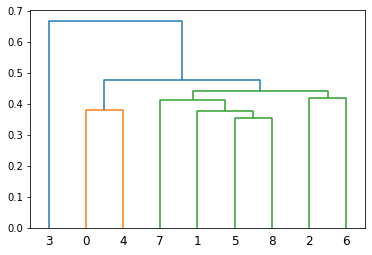

In [ ]:
allocation, linkage = get_allocations(x, True)
sch.dendrogram(linkage)

In [ ]:
allocation

,HRP,CLA
AAPL,0.251727,0.018738
DDOG,0.028210,-0.000000
FSLY,0.008156,0.000000
IBM,0.337175,0.528032
MSFT,0.260342,0.408773
NET,0.018863,0.000000
PLTR,0.015656,0.000000
SNOW,0.044537,0.000000
ZS,0.035334,0.044457


In [ ]:
start = 0
end = 24

data_weekly = [g[1] for g in list(data.groupby(pd.Grouper(freq = 'W')))]
print(len(data_weekly))
data_weekly[0]

53


,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-02-18,128.943619,106.400002,80.199997,110.034668,241.820251,82.790001,25.17,289.779999,223.380005
2021-02-19,129.102676,105.050003,80.680000,108.448807,239.023056,82.169998,29.00,290.000000,226.029999


In [ ]:
portfolio_data = pd.concat(data_weekly[start:end])
portfolio_data

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-02-18,128.943619,106.400002,80.199997,110.034668,241.820251,82.790001,25.170000,289.779999,223.380005
2021-02-19,129.102676,105.050003,80.680000,108.448807,239.023056,82.169998,29.000000,290.000000,226.029999
2021-02-22,125.255547,99.699997,76.389999,110.153145,232.615265,78.379997,28.000000,269.649994,213.449997
2021-02-23,125.116371,98.669998,77.910004,110.016434,231.385284,77.279999,26.750000,269.079987,206.509995
2021-02-24,124.609383,99.360001,75.760002,112.294975,232.654938,76.430000,26.389999,273.519989,207.809998
...,...,...,...,...,...,...,...,...,...
2021-07-26,148.361298,109.790001,48.970001,131.576050,287.376617,116.730003,22.129999,268.799988,234.520004
2021-07-27,146.150665,109.620003,48.169998,131.557617,284.881195,115.470001,21.680000,262.679993,233.029999
2021-07-28,144.368210,111.449997,50.349998,130.654465,284.563019,119.750000,22.559999,269.359985,236.839996


In [ ]:
x = np.log(portfolio_data / portfolio_data.shift()) / (1 / 252) # Para anualizar los retornos
x.dropna(inplace = True)
x

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-02-19,0.310662,-3.217822,1.503744,-3.658346,-2.931937,-1.894295,35.694040,0.191246,2.971924
2021-02-22,-7.623505,-13.172244,-13.769010,3.929534,-6.847886,-11.899816,-8.843013,-18.334543,-14.430813
2021-02-23,-0.280161,-2.616948,4.965048,-0.312952,-1.336015,-3.561663,-11.508849,-0.533261,-8.329555
2021-02-24,-1.023213,1.756111,-7.051939,5.165840,1.378990,-2.787090,-3.414435,4.124238,1.581395
2021-02-25,-8.921295,-11.307929,-12.163766,-1.518098,-6.045608,-16.028618,-24.343047,-12.445335,-15.014555
...,...,...,...,...,...,...,...,...,...
2021-07-26,0.728386,-3.283737,-4.336570,2.536797,-0.539963,-1.098592,3.670521,3.663984,-4.473109
2021-07-27,-3.783139,-0.390498,-4.150820,-0.035305,-2.197787,-2.734915,-5.177069,-5.803820,-1.606171
2021-07-28,-3.092291,4.172154,11.154076,-1.735964,-0.281609,9.171658,10.026630,6.328271,4.086834


In [ ]:
allocations = get_allocations(x)
allocations

[['IBM', 'AAPL', 'MSFT', 'PLTR', 'SNOW', 'FSLY', 'ZS', 'DDOG', 'NET']]
[['IBM', 'AAPL', 'MSFT', 'PLTR'], ['SNOW', 'FSLY', 'ZS', 'DDOG', 'NET']]
[['IBM', 'AAPL'], ['MSFT', 'PLTR'], ['SNOW', 'FSLY'], ['ZS', 'DDOG', 'NET']]
[['IBM'], ['AAPL'], ['MSFT'], ['PLTR'], ['SNOW'], ['FSLY'], ['ZS'], ['DDOG', 'NET']]
[['DDOG'], ['NET']]


,HRP,CLA
AAPL,0.218305,0.000000
DDOG,0.015822,0.000000
FSLY,0.014099,0.000000
IBM,0.341775,0.543043
MSFT,0.298879,0.335260
NET,0.011264,0.000000
PLTR,0.035875,0.008925
SNOW,0.028676,0.000000
ZS,0.035305,0.112771


In [ ]:
start_price = data_weekly[end-1].iloc[-1, :]
end_price = data_weekly[end].iloc[-1, :]
change = end_price - start_price
change

AAPL     0.496826
DDOG    21.220001
FSLY    -6.829998
IBM      2.884583
MSFT     4.523651
NET      0.190002
PLTR     0.110001
SNOW    11.760010
ZS       6.139999
dtype: float64

In [ ]:
allocations.mul(change, 0)

,HRP,CLA
AAPL,0.108460,0.000000
DDOG,0.335738,0.000000
FSLY,-0.096295,-0.000000
IBM,0.985879,1.566452
MSFT,1.352026,1.516599
NET,0.002140,0.000000
PLTR,0.003946,0.000982
SNOW,0.337228,0.000000
ZS,0.216773,0.692414


In [ ]:
allocations.mul(change, 0).sum()

HRP    3.245896
CLA    3.776447
dtype: float64

# Comparación

In [ ]:
start = 0
end = 24

periods_ = range(len(data_weekly) - end)
earnings = np.zeros((len(periods_), 2))
alloc_list = []

for i in periods_:
    portfolio_data = pd.concat(data_weekly[start:end])

    x = np.log(portfolio_data / portfolio_data.shift(periods=5)) # / (1 / 252) # Para anualizar los retornos
    x.dropna(inplace = True)

    allocations = get_allocations(x)
    alloc_list.append(allocations)

    start_price = data_weekly[end-1].iloc[-1, :]
    end_price = data_weekly[end].iloc[-1, :]
    change = end_price - start_price

    earnings[i, :] = allocations.mul(change, 0).sum()

    start += 1
    end += 1


[['IBM', 'AAPL', 'MSFT', 'SNOW', 'PLTR', 'DDOG', 'ZS', 'FSLY', 'NET']]
[['IBM', 'AAPL', 'MSFT', 'SNOW'], ['PLTR', 'DDOG', 'ZS', 'FSLY', 'NET']]
[['IBM', 'AAPL'], ['MSFT', 'SNOW'], ['PLTR', 'DDOG'], ['ZS', 'FSLY', 'NET']]
[['IBM'], ['AAPL'], ['MSFT'], ['SNOW'], ['PLTR'], ['DDOG'], ['ZS'], ['FSLY', 'NET']]
[['FSLY'], ['NET']]
[['IBM', 'AAPL', 'MSFT', 'SNOW', 'PLTR', 'FSLY', 'NET', 'DDOG', 'ZS']]
[['IBM', 'AAPL', 'MSFT', 'SNOW'], ['PLTR', 'FSLY', 'NET', 'DDOG', 'ZS']]
[['IBM', 'AAPL'], ['MSFT', 'SNOW'], ['PLTR', 'FSLY'], ['NET', 'DDOG', 'ZS']]
[['IBM'], ['AAPL'], ['MSFT'], ['SNOW'], ['PLTR'], ['FSLY'], ['NET'], ['DDOG', 'ZS']]
[['DDOG'], ['ZS']]
[['IBM', 'AAPL', 'MSFT', 'SNOW', 'PLTR', 'DDOG', 'ZS', 'FSLY', 'NET']]
[['IBM', 'AAPL', 'MSFT', 'SNOW'], ['PLTR', 'DDOG', 'ZS', 'FSLY', 'NET']]
[['IBM', 'AAPL'], ['MSFT', 'SNOW'], ['PLTR', 'DDOG'], ['ZS', 'FSLY', 'NET']]
[['IBM'], ['AAPL'], ['MSFT'], ['SNOW'], ['PLTR'], ['DDOG'], ['ZS'], ['FSLY', 'NET']]
[['FSLY'], ['NET']]
[['IBM', 'AAPL', 'MSFT'

In [ ]:
earnings = pd.DataFrame(earnings, columns = ['HRP', 'CLA'])

In [ ]:
import plotly.express as px
fig = px.line(earnings.cumsum(), markers = True)
fig.update_layout(hovermode = 'x')
fig.show()

In [ ]:
px.line(data)